In [19]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM, Flatw0waCDM
from reportlab.graphics.renderPM import drawToPIL

from wowadis_muilt import run_cosmological_distances_multiprocessing,dh_inmpc,bao_dv_distance,bao_dv_dr,bao_fap,sne_luminosity_distance,log_likelihood, dm_inmpc,sne_distmod, run_lcdm_om0_by_multiprocessing,run_lcdm_methods_om0_by_multiprocessing, run_gaussian_methods_om0_by_multiprocessing, calculate_om0_distributions, run_mcmc
from scipy.optimize import minimize
import emcee
import matplotlib.pyplot as plt
import corner
import pandas as pd
from scipy.spatial import KDTree
import astropy.units as u
from scipy.stats import gaussian_kde
import gzip

data = np.genfromtxt('data/DES-SN5YR_HD.csv',
                     delimiter=',', names=True, dtype=None, encoding='utf-8')
zHEL_array = data['zHEL']
MUERR_FINAL_array = data['MUERR_FINAL']

with gzip.open('data/STAT+SYS.txt.gz', 'rt') as f:
    data = np.loadtxt(f, skiprows=1)
print("Data shape before reshape:", data.shape)

C_SYS = data.reshape((1829, 1829))
print("C_SYS shape after reshape:", C_SYS.shape)
cov_matrix_sne = np.diag(MUERR_FINAL_array ** 2) + C_SYS


print(zHEL_array)
print(MUERR_FINAL_array)
z_desy5 = np.array(zHEL_array)
des_sne_cosmo_wowa = Flatw0waCDM(H0=70, Om0=0.495, w0=-0.36, wa=-8.8)
distmod_error_desy5 = np.array(MUERR_FINAL_array)
#sne_distmod
des_distmod_compare_desy5 = sne_distmod(z=z_desy5, H0=70, Om0=0.495, w0=-0.36, wa=-8.8, cosmo=des_sne_cosmo_wowa)
# from paper:
zeff = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
dm_rd = np.array([0, 13.62, 16.85, 21.71, 27.79, 0, 39.71])
delta_dm_rd = np.array([0, 0.25, 0.32, 0.28, 0.69, 0, 0.94])
dh_rd = np.array([0, 20.98, 20.08, 17.88, 13.82, 0, 8.52])
delta_dh_rd =np.array( [0, 0.61, 0.60, 0.35, 0.42, 0, 0.17])
dv_rd =np.array([7.93, -0.445, -0.420, -0.389, -0.444, 26.07, -0.447])
delata_dv_rd = [0.15, None, None, None, None, 0.67,None]
rdrag = 147.18 * u.Mpc
coefficient_r= np.array([np.nan, -0.445, -0.420, -0.389, -0.444, np.nan, -0.447])
#few definition for calculation both the error bar of BAO DV&FAP and also draw the plot
def delta_ab(delta_a, delta_b, r):
    _delta_a= np.nan_to_num(delta_a, nan=0.0)
    _delta_b= np.nan_to_num(delta_b, nan=0.0)
    _r= np.nan_to_num(np.array(r), nan=0.0)
    return _r*_delta_a*_delta_b

def from_data_to_dvmet(z,dm_rd,dh_rd):
    dm_rd = np.array(dm_rd)
    dh_rd = np.array(dh_rd)
    z = np.array(z)
    dm = dm_rd
    dh = dh_rd
    dv = ((dm ** 2) * dh * (z)) ** (1 / 3)
    return dv

def from_data_to_fap(z,dm_rd,dh_rd):
    dm = dm_rd * 147.18
    dh = dh_rd * 147.18
    fap = (dm / dh)
    return fap

def delta_DV(z, delta_DM, delta_DH, DM, DH, coefficient):
    #DV = ((DM ** 2) * DH * (z)) ** (1 / 3)
    partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
    partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))
    _partial_DM = np.nan_to_num(partial_DM, nan=0.0)
    _partial_DH = np.nan_to_num(partial_DH, nan=0.0)
    _delta_DM = np.nan_to_num(delta_DM, nan=0.0)
    _delta_DH = np.nan_to_num(delta_DH, nan=0.0)
    covariance_term = delta_ab(_partial_DM* _delta_DM, _partial_DH * _delta_DH, coefficient)

    sigma_DV = np.sqrt((partial_DM * delta_DM)**2 + (partial_DH * delta_DH)**2+ 2 * covariance_term)
    return sigma_DV

def delta_FAP(delta_DM, delta_DH, DM, DH, coefficient):
    FAP = (DM / DH)
    coefficient = np.nan_to_num(coefficient, nan=0.0)

    covariance_term = delta_ab((delta_DM / DH), (DM * delta_DH / (DH**2)), coefficient)

    sigma_FAP = np.sqrt((delta_DM / DH)**2 + ((DM * delta_DH) / (DH**2))**2 - 2* covariance_term)
    return sigma_FAP

dv = from_data_to_dvmet(zeff,dm_rd,dh_rd)
print('dv',dv)

delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r)
print('delta dv',delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r))

zeff_array = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
_compare_cosmo_bao = FlatLambdaCDM(H0=70, Om0=0.3)
_dv_dr_compare = bao_dv_dr(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0)

_dh_dr_compare  = dh_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18
_dm_dr_compare  = dm_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18

print(((_dh_dr_compare)*((_dm_dr_compare**2)*zeff_array))**(1/3))
print(_dv_dr_compare)
delta_dv_imcom = delta_DV(zeff, delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_dv_imcom) #incomplete
delta_dv = delta_dv_imcom
delta_dv[0] = 0.15  #same as in table1 of desi paper
delta_dv[5] = 0.67
print(delta_dv)
_delta_dv = delta_dv
zeff_fap = np.delete(zeff_array, [0, 5])
_fap_compare = bao_fap(zeff_fap, H0=70, Om0=0.3, w0=-1.0, wa=0)
print(_fap_compare)
#(delta_DM, delta_DH, DM, DH)
delta_fap_imcom = delta_FAP(delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_fap_imcom)
delta_fap = np.delete(delta_fap_imcom, [0, 5])
print(delta_fap)
#bao part:
print(zeff_array)
print(delta_dv)

print('zeff_fap',zeff_fap)
print(delta_fap)

#SNe part:
print(z_desy5)
print(distmod_error_desy5)

print('xxxxxxxxxxxxX')

file_path = 'data/fw0wacdm_SN_emcee.txt'
data_SN = pd.read_csv(file_path, sep='\s+', comment='#', header=None)
data_SN.columns = ['omega_m', 'w', 'wa', 'prior', 'post']
data_subset_SN = data_SN[['w', 'wa', 'omega_m']]
param_combinations_desy5 = data_subset_SN.to_numpy()

H0_column_sn_desy5 = np.full((param_combinations_desy5.shape[0], 1), 70.0)

param_combinations_desy5 = np.hstack((param_combinations_desy5,H0_column_sn_desy5))

if len(param_combinations_desy5) >= 20000:
    # Randomly select 20,000 rows
    random_indices = np.random.choice(param_combinations_desy5.shape[0], 4000, replace=False)
    lw_params = param_combinations_desy5[random_indices]

file_path_2 = 'data/fw0wacdm_planck+SN+eBOSS+3x2pt.txt'
data_sn_bao_cmb = pd.read_csv(file_path_2, sep='\s+', comment='#', header=None)
column_names_bao_cmb = [
    'omega_m', 'h0', 'omega_b', 'n_s', 'a_s', 'w', 'wa', 'mnu', 'tau',
    'shear_calibration_m1', 'shear_calibration_m2', 'shear_calibration_m3', 'shear_calibration_m4',
    'wl_photoz_bias_1', 'wl_photoz_bias_2', 'wl_photoz_bias_3', 'wl_photoz_bias_4',
    'lens_photoz_bias_1', 'lens_photoz_bias_2', 'lens_photoz_bias_3', 'lens_photoz_bias_4',
    'lens_photoz_width_1', 'lens_photoz_width_2', 'lens_photoz_width_3', 'lens_photoz_width_4',
    'bias_lens_b1', 'bias_lens_b2', 'bias_lens_b3', 'bias_lens_b4',
    'intrinsic_alignment_a1', 'intrinsic_alignment_a2', 'intrinsic_alignment_alpha1', 'intrinsic_alignment_alpha2',
    'intrinsic_alignment_bias_ta', 'prior', 'like', 'post', 'weight'
]
data_sn_bao_cmb.columns = column_names_bao_cmb
data_sn_bao_cmb = data_sn_bao_cmb[['w', 'wa', 'omega_m','h0']]
data_sn_bao_cmb['h0'] = data_sn_bao_cmb['h0'] * 100
param_combinations_sn_bao_cmb = data_sn_bao_cmb.to_numpy()

random_indices_sbc = np.random.choice(param_combinations_sn_bao_cmb.shape[0], 10000, replace=False)
lw_params_sn_bao_cmb = param_combinations_sn_bao_cmb[random_indices_sbc]

z_all = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_err_all = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}

des_sne_cosmo_wowachose = Flatw0waCDM(H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05)
des_distmod_compare_desy5_wowachose = sne_distmod(z=z_desy5, H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05,cosmo=des_sne_cosmo_wowachose)

dv_dr_compare_wowachose = bao_dv_dr(zeff_array, H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05)
fap_compare_wowachose = bao_fap(zeff_fap, H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05)
z_bao_w0wa_wowachose = {'dv': zeff_array, 'fap': zeff_fap}
data_obs_bao_wowachose = {'dv': dv_dr_compare_wowachose, 'fap': fap_compare_wowachose}
data_err_bao_wowachose = {'dv': delta_dv, 'fap': delta_fap}

z_all = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_obs_all = {'sne': des_distmod_compare_desy5_wowachose, 'dv': dv_dr_compare_wowachose, 'fap': fap_compare_wowachose}
data_err_all = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}

#cov_matrix_sne

Data shape before reshape: (3345241,)
C_SYS shape after reshape: (1829, 1829)
[0.24651 0.336   0.38388 ... 0.02561 0.02448 0.092  ]
[0.0968 0.136  0.2332 ... 0.1237 0.116  0.2873]
dv [ 0.         12.56733789 15.90704123 19.86354247 24.13368485  0.
 31.51604873]
delta dv [       nan 0.14769734 0.19712699 0.1695468  0.36418021        nan
 0.44508433]
[ 7.78277361 12.43113123 15.97929259 19.34675898 23.81612642 25.39850208
 30.66427324]
[ 7.83003238 12.50661589 16.0763225  19.46423691 23.96074337 25.55272757
 30.8504737 ]
[0.         0.14870767 0.19699585 0.16942324 0.36576218 0.
 0.45039171]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
[0.59053747 0.87174805 1.235266   1.97072542 4.5056629 ]
[0.         0.02361165 0.03654867 0.03482655 0.09344398 0.
 0.17147831]
[0.02361165 0.03654867 0.03482655 0.09344398 0.17147831]
[0.295 0.51  0.706 0.93  1.317 1.491 2.33 ]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
zeff_fap [0.51  0.706 0.9

/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_28358/601994923.py:71: RuntimeWarning: invalid value encountered in divide
  partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_28358/601994923.py:72: RuntimeWarning: invalid value encountered in divide
  partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))


In [20]:
import numpy as np
import scipy.integrate as integrate
import gzip

#---------------------------------------
# Constants and fiducial parameters
#---------------------------------------
c = 299792.458  # km/s
Omm_fid = 0.316
H0_fid = 67.24
w0_fid = -0.727
wa_fid = -1.05

def c_s(z):
    """
    Speed of sound in the plasma.
    For a real analysis, implement c_s(z) properly.
    Here, it's assumed constant for demonstration purposes.
    """
    return 1.0

In [21]:
def E_w0wa(z, Omm, H0, w0, wa):
    """
    Computes the dimensionless Hubble parameter E(z) = H(z)/H0.
    """
    if w0 == -1 and wa == 0:
        # LCDM case
        return np.sqrt(Omm * (1 + z)**3 + (1.0 - Omm))
    else:
        # General w0wa
        X = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
        return np.sqrt(Omm * (1 + z)**3 + (1.0 - Omm) * X)

def I_z(z, Omm, H0, w0, wa):
    """
    Computes the integral I(z) = ∫0^z dz'/E(z')
    """
    def integrand(zp):
        return 1.0 / E_w0wa(zp, Omm, H0, w0, wa)
    val, _ = integrate.quad(integrand, 0, z, limit=500)
    return val

# SNe

In [22]:
def dL(z, Omm, H0, w0, wa):
    """
    Luminosity distance d_L(z) in Mpc.
    """
    return (1 + z) * (c / H0) * I_z(z, Omm, H0, w0, wa)

def mu_z(z, Omm, H0, w0, wa):
    """
    Distance modulus μ(z).
    """
    dl = dL(z, Omm, H0, w0, wa)
    return 5 * np.log10(dl) + 25.0

# Partial Derivatives for SNe (Analytical)
def dE_dOmm(z, Omm, H0, w0, wa):
    """
    Partial derivative of E(z) with respect to Omega_m at given w0, wa.
    """
    Ez = E_w0wa(z, Omm, H0, w0, wa)
    return ((1 + z)**3 - 1) / (2 * Ez)

def dI_dOmm(z, Omm, H0, w0, wa):
    """
    Partial derivative of I(z) with respect to Omega_m.
    """
    def integrand(zp):
        Ez = E_w0wa(zp, Omm, H0, w0, wa)
        return -(1.0 / Ez**2) * dE_dOmm(zp, Omm, H0, w0, wa)
    val, _ = integrate.quad(integrand, 0, z, limit=500)
    return val

def dL_dOmm(z, Omm, H0, w0, wa):
    """
    Partial derivative of dL(z) with respect to Omega_m.
    """
    return (1 + z) * (c / H0) * dI_dOmm(z, Omm, H0, w0, wa)

def dL_dH0(z, Omm, H0, w0, wa):
    """
    Partial derivative of dL(z) with respect to H0.
    """
    I_val = I_z(z, Omm, H0, w0, wa)
    return (1 + z) * c * (-1 / H0**2) * I_val

def dmu_dOmm(z, Omm, H0, w0, wa):
    """
    Partial derivative of μ(z) with respect to Omega_m.
    """
    dl = dL(z, Omm, H0, w0, wa)
    ddl = dL_dOmm(z, Omm, H0, w0, wa)
    return (5 / np.log(10)) * (ddl / dl)

def dmu_dH0(z, Omm, H0, w0, wa):
    """
    Partial derivative of μ(z) with respect to H0.
    """
    dl = dL(z, Omm, H0, w0, wa)
    ddl = dL_dH0(z, Omm, H0, w0, wa)
    return (5 / np.log(10)) * (ddl / dl)

# BAO

In [23]:
def D_M(z, Omm, H0, w0, wa):
    """
    Transverse comoving distance D_M(z).
    """
    return (c / H0) * I_z(z, Omm, H0, w0, wa)

def E(z, Omm, H0, w0, wa):
    """
    Dimensionless Hubble parameter E(z).
    """
    return E_w0wa(z, Omm, H0, w0, wa)

def D_V(z, Omm, H0, w0, wa):
    """
    Volume-averaged distance D_V(z).
    """
    DH = c / H0
    return (z * DH * (D_M(z, Omm, H0, w0, wa)**2))**(1/3)

def F_AP(z, Omm, H0, w0, wa):
    """
    Alcock-Paczynski parameter F_AP(z).
    """
    return E(z, Omm, H0, w0, wa) * I_z(z, Omm, H0, w0, wa)

def dDV_dOmm(z, Omm, H0, w0, wa):
    """
    Partial derivative of D_V(z) with respect to Omega_m.
    """
    Ival = I_z(z, Omm, H0, w0, wa)
    dI_dO = dI_dOmm(z, Omm, H0, w0, wa)
    dE_dO = dE_dOmm(z, Omm, H0, w0, wa)
    return D_V(z, Omm, H0, w0, wa) * ((2 / 3) * (dI_dO / Ival) - (1 / 3) * (dE_dO / E(z, Omm, H0, w0, wa)))

def dDV_dH0(z, Omm, H0, w0, wa):
    """
    Partial derivative of D_V(z) with respect to H0.
    """
    return -D_V(z, Omm, H0, w0, wa) / H0

def dFAP_dOmm(z, Omm, H0, w0, wa):
    """
    Partial derivative of F_AP(z) with respect to Omega_m.
    """
    return dE_dOmm(z, Omm, H0, w0, wa) * I_z(z, Omm, H0, w0, wa) + E(z, Omm, H0, w0, wa) * dI_dOmm(z, Omm, H0, w0, wa)

def dFAP_dH0(z, Omm, H0, w0, wa):
    """
    Partial derivative of F_AP(z) with respect to H0.
    """
    # F_AP does not depend on H0 in this setup
    return 0.0

# CMB

In [24]:
from cmb_v1 import la_rzs_from_cosmoparams, CMBParams

omegabh2_fid = 0.02218
omk_fid = 0.0
omnuh2_fid = 0.00064
nnu_fid = 3.046

dOmm = 0.0005
dH0 = 0.01


In [25]:
sne_data_path = 'data/DES-SN5YR_HD.csv'
data_sne = np.genfromtxt(sne_data_path, delimiter=',', names=True, dtype=None, encoding='utf-8')
zHEL_array = data_sne['zHEL']
MUERR_FINAL_array = data_sne['MUERR_FINAL']

sys_cov_path = 'data/STAT+SYS.txt.gz'
with gzip.open(sys_cov_path, 'rt') as f:
    data_stat_sys = np.loadtxt(f, skiprows=1)
C_SYS = data_stat_sys.reshape((1829, 1829))
cov_matrix_sne = np.diag(MUERR_FINAL_array**2) + C_SYS

mu_fid = np.array([mu_z(z, Omm_fid, H0_fid, w0_fid, wa_fid) for z in zHEL_array])
mu_lcdm_fid = np.array([mu_z(z, Omm_fid, H0_fid, -1, 0) for z in zHEL_array])
Delta_mu = mu_fid - mu_lcdm_fid

J_Omm_sne = np.array([dmu_dOmm(z, Omm_fid, H0_fid, w0_fid, wa_fid) for z in zHEL_array])
J_H0_sne = np.array([dmu_dH0(z, Omm_fid, H0_fid, w0_fid, wa_fid) for z in zHEL_array])

Cinv_sne = np.linalg.inv(cov_matrix_sne)
J_sne = np.vstack((J_Omm_sne, J_H0_sne)).T
F_sne = J_sne.T @ Cinv_sne @ J_sne

params_sne = np.linalg.inv(F_sne) @ (J_sne.T @ Cinv_sne @ Delta_mu)
Omm_ML_sne = Omm_fid + params_sne[0]
H0_ML_sne = H0_fid + params_sne[1]
cov_sne = np.linalg.inv(F_sne)
sigma_Omm_sne = np.sqrt(cov_sne[0, 0])
sigma_H0_sne = np.sqrt(cov_sne[1, 1])

print("SNe Results:")
print(f"Omega_m_ML: {Omm_ML_sne:.5f} +/- {sigma_Omm_sne:.5f}")

SNe Results:
Omega_m_ML: 0.35046 +/- 0.01656


In [26]:
zeff_dv = zeff_array
delta_dv = _delta_dv * 147.18

zeff_fap = zeff_fap
delta_fap =delta_fap

DV_fid = np.array([D_V(z, Omm_fid, H0_fid, w0_fid, wa_fid) for z in zeff_dv])
FAP_fid = np.array([F_AP(z, Omm_fid, H0_fid, w0_fid, wa_fid) for z in zeff_fap])
bao_fid = np.concatenate((DV_fid, FAP_fid))

DV_lcdm_fid = np.array([D_V(z, Omm_fid, H0_fid, -1, 0) for z in zeff_dv])
FAP_lcdm_fid = np.array([F_AP(z, Omm_fid, H0_fid, -1, 0) for z in zeff_fap])
bao_lcdm_fid = np.concatenate((DV_lcdm_fid, FAP_lcdm_fid))

Delta_bao = bao_fid - bao_lcdm_fid

J_Omm_bao = []
J_H0_bao = []

for z in zeff_dv:
    J_Omm_bao.append(dDV_dOmm(z, Omm_fid, H0_fid, w0_fid, wa_fid))
    J_H0_bao.append(dDV_dH0(z, Omm_fid, H0_fid, w0_fid, wa_fid))

for z in zeff_fap:
    J_Omm_bao.append(dFAP_dOmm(z, Omm_fid, H0_fid, w0_fid, wa_fid))
    J_H0_bao.append(dFAP_dH0(z, Omm_fid, H0_fid, w0_fid, wa_fid))

J_Omm_bao = np.array(J_Omm_bao)
J_H0_bao = np.array(J_H0_bao)


F_bao = np.zeros((2, 2))

for i in range(len(zeff_dv)):
    sigma = delta_dv[i]
    dO = J_Omm_bao[i]
    dH = J_H0_bao[i]
    F_bao += np.outer([dO, dH], [dO, dH]) / sigma**2

for j in range(len(zeff_fap)):
    idx = len(zeff_dv) + j
    sigma = delta_fap[j]
    dO = J_Omm_bao[idx]
    dH = J_H0_bao[idx]  #  0.0
    F_bao += np.outer([dO, dH], [dO, dH]) / sigma**2

sum_term_Omm = 0.0
sum_term_H0 = 0.0

for i in range(len(zeff_dv)):
    sigma = delta_dv[i]
    sum_term_Omm += J_Omm_bao[i] * Delta_bao[i] / sigma**2
    sum_term_H0 += J_H0_bao[i] * Delta_bao[i] / sigma**2

for j in range(len(zeff_fap)):
    idx = len(zeff_dv) + j
    sigma = delta_fap[j]
    sum_term_Omm += J_Omm_bao[idx] * Delta_bao[idx] / sigma**2
    sum_term_H0 += J_H0_bao[idx] * Delta_bao[idx] / sigma**2

sum_vector = np.array([sum_term_Omm, sum_term_H0])

delta_theta_bao = np.linalg.inv(F_bao) @ sum_vector
Omm_ML_bao = Omm_fid + delta_theta_bao[0]
H0_ML_bao = H0_fid + delta_theta_bao[1]
cov_bao_final = np.linalg.inv(F_bao)
sigma_Omm_bao = np.sqrt(cov_bao_final[0, 0])
sigma_H0_bao = np.sqrt(cov_bao_final[1, 1])

print("\nBAO Results:")
print(f"Omega_m_ML: {Omm_ML_bao:.5f} +/- {sigma_Omm_bao:.5f}")
print(f"H0_ML: {H0_ML_bao:.2f} +/- {sigma_H0_bao:.2f} km/s/Mpc")


BAO Results:
Omega_m_ML: 0.29536 +/- 0.01543
H0_ML: 68.96 +/- 0.80 km/s/Mpc


In [27]:

numla_fid, numr_fid = la_rzs_from_cosmoparams(H0=H0_fid, omegam=Omm_fid, omegabh2=omegabh2_fid, omk=omk_fid, omnuh2=omnuh2_fid, w=w0_fid, wa=wa_fid, nnu=nnu_fid)

numla_lcdm, numr_lcdm = la_rzs_from_cosmoparams(H0=H0_fid, omegam=Omm_fid, omegabh2=omegabh2_fid, omk=omk_fid, omnuh2=omnuh2_fid, w=-1, wa=0, nnu=nnu_fid)

numla_plus_omm, numr_plus_omm = la_rzs_from_cosmoparams(H0=H0_fid, omegam=Omm_fid+dOmm, omegabh2=omegabh2_fid, omk=omk_fid, omnuh2=omnuh2_fid, w=w0_fid, wa=wa_fid, nnu=nnu_fid)
numla_minus_omm, numr_minus_omm = la_rzs_from_cosmoparams(H0=H0_fid, omegam=Omm_fid-dOmm, omegabh2=omegabh2_fid, omk=omk_fid, omnuh2=omnuh2_fid, w=w0_fid, wa=wa_fid, nnu=nnu_fid)

numdla_dOmm = (numla_plus_omm - numla_minus_omm) / (2*dOmm)
numdr_dOmm = (numr_plus_omm - numr_minus_omm) / (2*dOmm)

numla_plus_h, numr_plus_h = la_rzs_from_cosmoparams(H0=H0_fid+dH0, omegam=Omm_fid, omegabh2=omegabh2_fid, omk=omk_fid, omnuh2=omnuh2_fid, w=w0_fid, wa=wa_fid, nnu=nnu_fid)
numla_minus_h, numr_minus_h = la_rzs_from_cosmoparams(H0=H0_fid-dH0, omegam=Omm_fid, omegabh2=omegabh2_fid, omk=omk_fid, omnuh2=omnuh2_fid, w=w0_fid, wa=wa_fid, nnu=nnu_fid)

numdla_dH0 = (numla_plus_h - numla_minus_h) / (2*dH0)
numdr_dH0 = (numr_plus_h - numr_minus_h) / (2*dH0)

numJ_cmb = np.array([
    [numdr_dOmm, numdr_dH0],
    [numdla_dOmm, numdla_dH0]
])

print(numJ_cmb)
Delta_cmb = np.array([numr_lcdm - numr_fid, numla_lcdm - numla_fid])

numcov_cmb = np.array([
    [0.000043, 0.000328],
    [0.000328, 0.011046]
])
numCinv_cmb = np.linalg.inv(numcov_cmb)
numF_cmb = numJ_cmb.T @ numCinv_cmb @ numJ_cmb

params_cmb = np.linalg.inv(numF_cmb) @ (numJ_cmb.T @ numCinv_cmb @ Delta_cmb)
print(params_cmb)
Omm_ML_cmb = Omm_fid - params_cmb[0]
H0_ML_cmb = H0_fid - params_cmb[1]
cov_cmb = np.linalg.inv(numF_cmb)
sigma_Omm_cmb= np.sqrt(cov_cmb[0, 0])
sigma_H0_cmb = np.sqrt(cov_cmb[1, 1])


print(params_cmb)
print("CMB Fisher Results:")
print(f"Omega_m_ML: {Omm_ML_cmb:.5f} +/- {sigma_Omm_cmb:.5f}")
print(f"H0_ML: {H0_ML_cmb:.2f} +/- {sigma_H0_cmb:.2f} km/s/Mpc")

numcov_params = np.linalg.inv(numF_cmb)
numsigma_Omm = np.sqrt(numcov_params[0,0])
numsigma_H0 = np.sqrt(numcov_params[1,1])


[[ 5.51174389e-01  3.27547495e-04]
 [-1.39431778e+02 -2.14908887e+00]]
[ 0.00151415 -0.16109407]
[ 0.00151415 -0.16109407]
CMB Fisher Results:
Omega_m_ML: 0.31449 +/- 0.01239
H0_ML: 67.40 +/- 0.83 km/s/Mpc


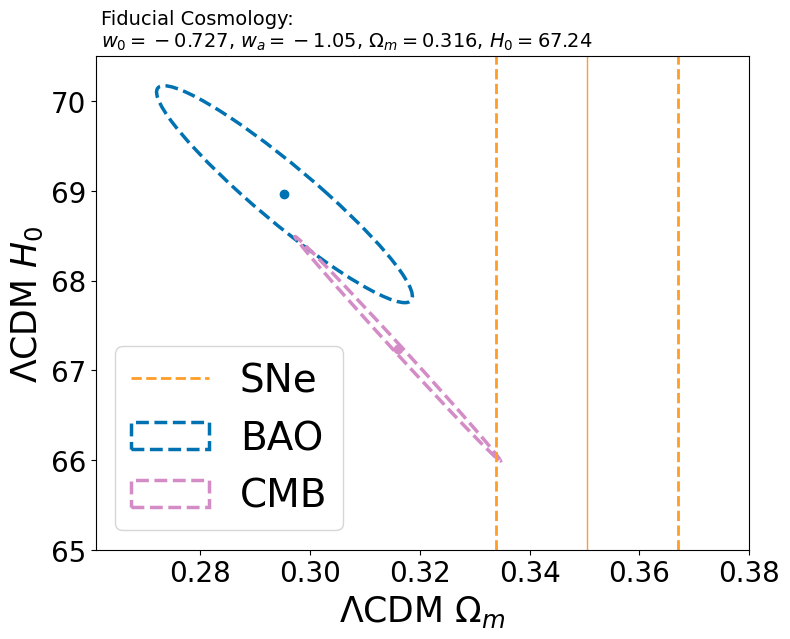

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle

def plot_ellipse(ax, mean, cov, color, label, linestyle='--'):
    """
    Plot a 68% confidence ellipse given a mean and covariance matrix.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.arctan2(*eigenvectors[:, 0][::-1])
    width, height = 2 * np.sqrt(2.28 * eigenvalues)  # 68% confidence
    ellipse = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=np.degrees(angle),
        edgecolor=color,
        fc='None',
        lw=2.5,
        linestyle=linestyle,
        label=label
    )
    ax.add_patch(ellipse)


omega_m_1sigma_min = Omm_ML_sne - sigma_Omm_sne
omega_m_1sigma_max = Omm_ML_sne + sigma_Omm_sne
h0_min = 63
h0_max = 73

fig, ax = plt.subplots(figsize=(8, 6.5))

x_values = [omega_m_1sigma_min, omega_m_1sigma_max, omega_m_1sigma_max, omega_m_1sigma_min, omega_m_1sigma_min]
y_values = [h0_min, h0_min, h0_max, h0_max, h0_min]

ax.axvline(omega_m_1sigma_min,color='#ff9d27', linestyle='--', label='SNe',lw=2)
ax.axvline(omega_m_1sigma_max,color='#ff9d27', linestyle='--',lw=2)

ax.plot([Omm_ML_sne, Omm_ML_sne], [h0_min, h0_max], color='#ff9d27', linestyle='-', lw=1)  # Solid line for center

plot_ellipse(ax, [Omm_ML_bao, H0_ML_bao], cov_bao_final, '#0072B2', 'BAO')
ax.plot(Omm_ML_bao, H0_ML_bao, 'o', color='#0072B2')

plot_ellipse(ax, [Omm_fid, H0_fid], numcov_params, '#d38cc6', 'CMB')
ax.plot(Omm_fid, H0_fid, 'o', color='#d38cc6')

ax.set_xlabel("$\Lambda$CDM $\Omega_{m}$", fontsize=25)
ax.set_ylabel("$\Lambda$CDM $H_{0}$", fontsize=25)
ax.legend(loc='lower left', fontsize=28)
ax.text(
    0.262, 70.6,
    "Fiducial Cosmology:\n$w_0=-0.727$, $w_a=-1.05$, $\\Omega_m=0.316$, $H_0=67.24$",
    fontsize=14,
    ha='left'
)

ax.set_xlim(0.261, 0.38)
ax.set_ylim(65, 70.5)
ax.grid(False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.tight_layout()
#plt.savefig('fisher.png', dpi=300)

plt.show()